# <center> GeNNus </center>


## <center> Imports

In [1]:
import torch
from torch.utils.data import Dataset

import torchaudio
import torchaudio.transforms

import sys, os

from pprint import pprint

from tqdm import tqdm

import json

import numpy as np

import matplotlib.pylab as plt
import seaborn as sns

import librosa
import librosa.display

import pandas as pd

from pathlib import Path


## <center> Data pre-processing </center>

In [2]:
def label_from_str_to_one_hot(label_str: str): 
  
  if label_str == "Pop":
    return torch.tensor([1, 0, 0, 0, 0, 0])
  
  if label_str == "Hip-Hop":
    return torch.tensor([0, 1, 0, 0, 0, 0])
  
  if label_str == "Electronic":
    return torch.tensor([0, 0, 1, 0, 0, 0])
  
  if label_str == "Rock":
    return torch.tensor([0, 0, 0, 1, 0, 0])

  if label_str == "Folk":
    return torch.tensor([0, 0, 0, 0, 1, 0])

  if label_str == "Jazz":
    return torch.tensor([0, 0, 0, 0, 0, 1])

In [3]:
def load_raw_audio_data(
  path, normalize_audio: bool, audio_num_frames: int, num_channels: int
):
  
  audio_tensor_list = []

  # TODO use glob instead of this
  for path, subdirs, files in tqdm(os.walk(path), colour="teal"):
    for name in tqdm(files, colour="turquoise"):
        
      file_audio_path = os.path.join(path, name)
      
      try:
        waveform, sample_rate = torchaudio.load(
          file_audio_path, normalize=normalize_audio,
          num_frames=audio_num_frames
        )
        
        label = file_audio_path.split("/")[-2]
        label_one_hot = label_from_str_to_one_hot(label)
        
        audio_tensor_list.append(
          {
            "waveform": waveform[0:num_channels], 
            "og_sample_rate": sample_rate,
            "label_one_hot": label_one_hot,
            "label": label
          }
        )
        
      except:
        print(f"[load_audio_data] error while loading {file_audio_path}")
        continue
  
  return audio_tensor_list
        
        

In [4]:
# "audio_hop" --> take one sample ever hop_length elements
def resample_audio(og_audio_list, hop_length: int):
  
  resampled_audio_tensor_list = []
  
  for audio in tqdm(og_audio_list, colour="steelblue"):
    
    resampled_waveform = torchaudio.functional.resample(
        audio["waveform"], 
        # as per Torch Audio docs, this is the way of performing "hopping" in a 
        # similar way as the Mel Spectrogram transform does
        orig_freq=hop_length, new_freq=1
      )
    
    resampled_audio_tensor_list.append(
      {
        "waveform": resampled_waveform.numpy(), 
        "og_sample_rate": audio["og_sample_rate"],
        "hop_length": hop_length,
        "label_one_hot": audio["label_one_hot"].numpy(),
        "label": audio["label"]
      }
    )
    
  return resampled_audio_tensor_list

In [5]:
DATASET_SIZE = "extra_small"

In [6]:
og_audio_list = load_raw_audio_data(
  path=f"./data/fma_{DATASET_SIZE}_organized_by_label/", 
  normalize_audio=True, 
  audio_num_frames=1320000,
  num_channels=1
)

0it [00:00, ?it/s]
100%|██████████| 5/5 [00:00<00:00, 24.21it/s]
7it [00:01,  4.85it/s]


In [7]:
hop_length = 128

hopped_audio_list = resample_audio(og_audio_list, hop_length)

100%|██████████| 30/30 [00:00<00:00, 113.98it/s]


In [8]:
# code taken from: https://stackoverflow.com/a/47626762

class NumpyEncoder(json.JSONEncoder):
  
  def default(self, obj):
    
    if isinstance(obj, np.ndarray):
      return obj.tolist()
    
    return json.JSONEncoder.default(self, obj)

def export_pre_processed_data(
  pre_processed_data, export_path: str, export_name: str
):
  
  with open(f"{export_path}/{export_name}", "w") as final:
    json.dump(pre_processed_data, final, cls=NumpyEncoder)

In [9]:
# my_file = Path(f"./data/fma_extra_small_hop_{hop_length}.json")

# if not my_file.is_file():

export_pre_processed_data(
  hopped_audio_list, 
  "./data", 
  f"fma_{DATASET_SIZE}_hop_length_{hop_length}.json"
)

In [10]:
hopped_audio_list[0]["waveform"].shape

(1, 10313)

In [11]:
def load_dataset_from_disk(dataset_path: str, data_type: str):
  f = open(dataset_path)

  pre_processed_data_from_disk = json.load(f)
  
  for i in range(len(pre_processed_data_from_disk)):
    
    pre_processed_data_from_disk[i][data_type] = torch.tensor(
      pre_processed_data_from_disk[i][data_type]
    )
  
  return pre_processed_data_from_disk

In [12]:
loaded_data = load_dataset_from_disk(
  f"./data/fma_{DATASET_SIZE}_hop_{hop_length}.json", data_type="waveform"
)

In [13]:
def get_mel_spectrogram_transform(
  sample_rate: int, n_fft, win_length, hop_length, n_mels
):

  return torchaudio.transforms.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    norm='slaney',
    onesided=True,
    n_mels=n_mels,
    mel_scale="htk",
  )

def get_mel_spectrogram(
  og_audio_list, n_fft, win_length, hop_length, n_mels, num_channels
):
  
  mel_spectrogram_tensor_list = []
  
  for audio in og_audio_list:
    
    mel_spectrogram_transform = get_mel_spectrogram_transform(
      audio["og_sample_rate"],
      n_fft=n_fft, win_length=win_length, hop_length=hop_length, n_mels=n_mels
    )
    
    mel_spectrogram = mel_spectrogram_transform(audio["waveform"])
    
    mel_spectrogram_tensor_list.append(
      {
        "mel_spectrogram": mel_spectrogram[:num_channels].numpy(), 
        "og_sample_rate": audio["og_sample_rate"],
        "label_one_hot": audio["label_one_hot"].numpy(),
        "label": audio["label"],
        "mel_spectrogram_config": {
          "n_fft": n_fft, 
          "win_length": win_length, 
          "hop_length": hop_length, 
          "n_mels": n_mels
        }
      }
    )
    
  return mel_spectrogram_tensor_list

In [14]:
n_fft=1024
win_length=None
hop_length=4096 
n_mels=16

In [15]:
mel_spectros = get_mel_spectrogram(
  og_audio_list, 
  n_fft=n_fft, 
  win_length=win_length, 
  hop_length=hop_length, 
  n_mels=n_mels,
  num_channels=1
)

In [16]:
pprint(mel_spectros[0]["mel_spectrogram"].shape)

(1, 16, 323)


In [17]:
def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)

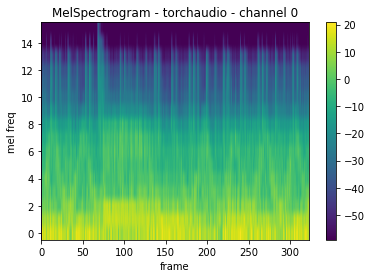

In [20]:
plot_spectrogram(
  mel_spectros[29]["mel_spectrogram"][0], title="MelSpectrogram - torchaudio - channel 0", ylabel='mel freq'
)

# plot_spectrogram(
#   mel_spectros[29]["mel_spectrogram"][1], title="MelSpectrogram - torchaudio - channel 1", ylabel='mel freq'
# )

In [21]:
# TODO place all songs of similar genre in the same Tensor, in order to perform the average.
# Plot that average and storytell it as the average spectrogram of the genre.

In [ ]:
# TODO place PCA and other non-linear dimensionality reductions here to show the data space

In [22]:
export_pre_processed_data(
  mel_spectros, 
  "./data", 
  f"fma_{DATASET_SIZE}_mel_spectrogram_n_fft_{n_fft}_win_length_{win_length}_" \
  f"hop_length_{hop_length}_n_mels_{n_mels}.json"
)

In [23]:
loaded_data = load_dataset_from_disk(
  "./data/" + 
    f"fma_{DATASET_SIZE}_mel_spectrogram_n_fft_{n_fft}_win_length_{win_length}_" +
    f"hop_length_{hop_length}_n_mels_{n_mels}.json",
  data_type="mel_spectrogram"
)